In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,r2_score
import joblib
import plotly.io as pio
pio.renderers.default = 'jupyterlab'

In [56]:
new_data1 = joblib.load('new_data1.joblib')
new_data1.head(3)

,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions
0,NonResidential,Hotel,downtown,47.61220,-122.33799,1927,1.0,12,88434,7226362.5,2003882.0,3946027.0,1276453.0,249.98
1,NonResidential,Hotel,downtown,47.61317,-122.33393,1996,1.0,11,103566,8387933.0,0.0,3242851.0,5145082.0,295.86
2,NonResidential,Hotel,downtown,47.61393,-122.33810,1969,1.0,41,956110,72587024.0,21566554.0,49526664.0,1493800.0,2089.28


#### one-hot-encoding

In [57]:
# one-hot-encoding
def get_ohe(df, column_name):
    ohe = OneHotEncoder(sparse=False)
    ohe.fit(df[[column_name]])
    temp_df = pd.DataFrame(data=ohe.transform(df[[column_name]]), columns=ohe.get_feature_names_out())
    df.drop(columns=[column_name], axis=1, inplace=True)
    df = pd.concat([df.reset_index(drop=True), temp_df], axis=1)
    return df

new_data1 = get_ohe(new_data1, 'BuildingType')
new_data1 = get_ohe(new_data1, 'PrimaryPropertyType')
new_data1 = get_ohe(new_data1, 'Neighborhood')

## Total GHG Emissions

In [58]:
#Je sélectionne les colonne pour la mettre dans la variable Y
y = new_data1[['TotalGHGEmissions']]

#Je sélectionne toutes les colonnes sauf la dernière (qui est ma cible) pour les mettre dans la variable X
X = new_data1.drop(['SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'], axis=1)

In [59]:
from sklearn import model_selection
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(X)
X_std = std_scale.transform(X)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_std, y, test_size=0.25)

In [60]:
# Créer une SVM avec un noyau gaussien de paramètre gamma=0.01
from sklearn import svm
reg = svm.SVR(kernel='rbf', gamma= 0.1)

# Entraîner la SVM sur le jeu d'entraînement
reg.fit(X_train, y_train)
# prédire sur le jeu de test
y_test_pred = reg.predict(X_test)


mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
mape = mean_absolute_percentage_error(y_test, y_test_pred)
r2= r2_score (y_test, y_test_pred)
print('MAE : ', mae, 'r2 : ', r2)
print('MSE : ', mse, ' MAPE: ', mape)

/Users/yixuanzhao/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MAE :  191.02491575729817 r2 :  -0.026016534181652062
MSE :  986652.7088602927  MAPE:  2.482901686513118


In [61]:
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance


perm_importance = permutation_importance(reg, X_train, y_train)

feature_names = X.columns
features = np.array(feature_names)



Text(0.5, 0, 'Permutation Importance')

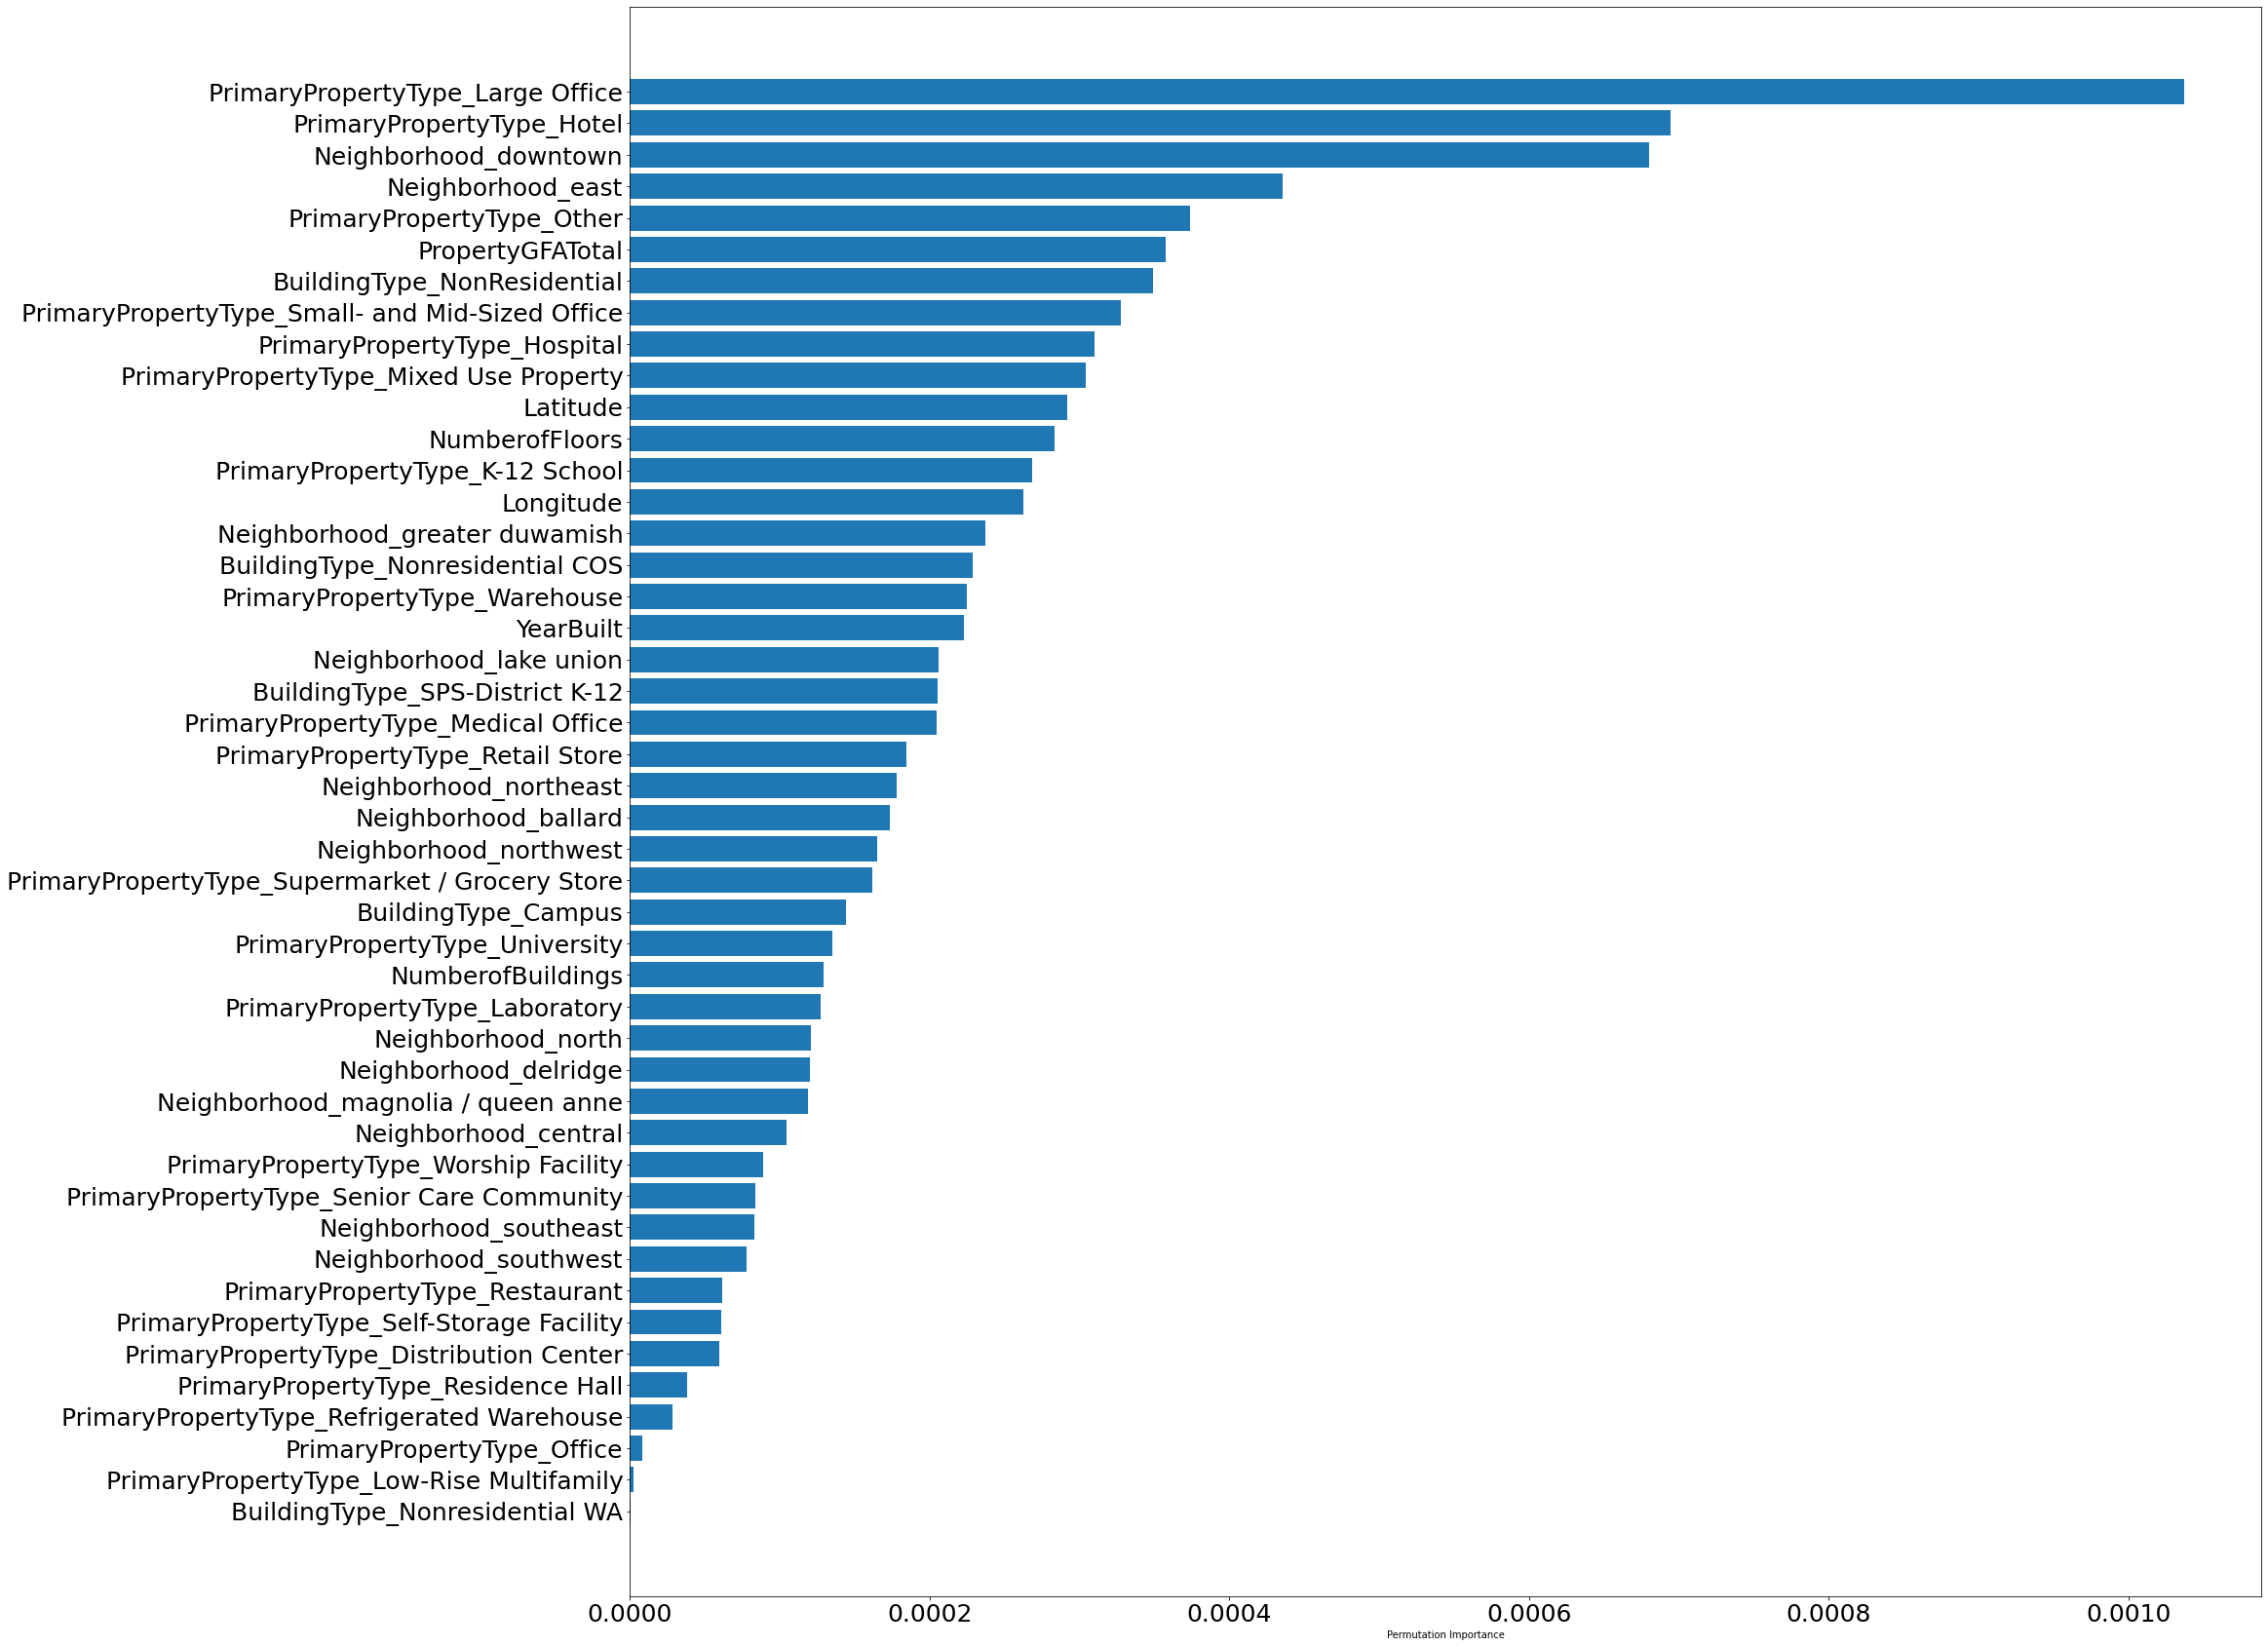

In [62]:
plt.figure(figsize=(30,30))
plt.yticks(
        rotation=0, 
        horizontalalignment='right',
        fontweight='light',
        fontsize=25 
)
plt.xticks(
        rotation=0, 
        fontweight='light',
        fontsize=25
)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")


In [63]:
# valeurs du paramètre C
C_range = np.logspace(-4, 4, 6)
# valeurs du paramètre gamma
gamma_range = np.logspace(-4, 4, 4)

# grille de paramètres
param_grid = {'C': C_range, 'gamma': gamma_range}

# score pour sélectionner le modèle optimal
score = 'neg_mean_absolute_error'

# initialiser la validation croisée
grid_pred = model_selection.GridSearchCV(svm.SVR(kernel='rbf'),
        param_grid,
        cv=5,
        scoring=score)
                                    
# exécuter la validation croisée sur le jeu d'entraînement
grid_pred.fit(X_train, y_train)

# prédire sur le jeu de test avec le modèle sélectionné 
best_grid = grid_pred.best_estimator_
y_test_pred_cv = best_grid.predict(X_test)


/Users/yixuanzhao/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/yixuanzhao/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/yixuanzhao/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/yixuanzhao/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ra

In [64]:
print(grid_pred.best_params_, grid_pred.best_score_)


{'C': 10000.0, 'gamma': 0.0001} -119.56146148027162


In [65]:
mae_cv = mean_absolute_error(y_test, y_test_pred_cv)
mse_cv = mean_squared_error(y_test, y_test_pred_cv)
mape_cv = mean_absolute_percentage_error(y_test, y_test_pred_cv)
r2_cv = r2_score (y_test, y_test_pred_cv)
print('MAE : ', mae_cv, 'r2 : ', r2_cv)
print('MSE : ', mse_cv, ' MAPE: ', mape_cv)

MAE :  155.02206334055887 r2 :  0.1318466103377337
MSE :  834846.0917344913  MAPE:  2.13848193852886


In [66]:
# Créer une SVM avec un noyau gaussien de paramètre gamma=0.01

reg_after = svm.SVR(kernel='rbf', C = 10000.0, gamma= 0.0001)

# Entraîner la SVM sur le jeu d'entraînement
reg_after.fit(X_train, y_train)
# prédire sur le jeu de test
y_test_pred_after = reg_after.predict(X_test)


mae_after = mean_absolute_error(y_test, y_test_pred_after)
mse_after = mean_squared_error(y_test, y_test_pred_after)
mape_after = mean_absolute_percentage_error(y_test, y_test_pred_after)
r2_after = r2_score (y_test, y_test_pred_after)
print('MAE : ', mae_after, 'r2 : ', r2_after)
print('MSE : ', mse_after, ' MAPE: ', mape_after)

/Users/yixuanzhao/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MAE :  155.02206334055887 r2 :  0.1318466103377337
MSE :  834846.0917344913  MAPE:  2.13848193852886


In [67]:
grid_pred.cv_results_['mean_fit_time']

array([0.07057209, 0.06664662, 0.06068735, 0.05063353, 0.06888266,
       0.06639304, 0.06115527, 0.05203748, 0.06856356, 0.06989679,
       0.05816493, 0.05166698, 0.06916666, 0.07058315, 0.06337738,
       0.05356159, 0.06841989, 0.08472366, 0.10523024, 0.08837891,
       0.08349028, 0.43023262, 0.1230556 , 0.0999845 ])

In [68]:
grid_pred.cv_results_['mean_score_time']

array([0.05683975, 0.05942807, 0.05696764, 0.05463552, 0.05926275,
       0.05894976, 0.05648117, 0.0535624 , 0.05664897, 0.209799  ,
       0.05358086, 0.05317969, 0.05894241, 0.05737586, 0.05691833,
       0.05463881, 0.0580749 , 0.06237221, 0.06106009, 0.05246091,
       0.05774112, 0.05634379, 0.05667615, 0.05433269])

## Site Energy Use (kBtu)

In [69]:
y2 = new_data1[['SiteEnergyUse(kBtu)']]
X2 = new_data1.drop(['SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'], axis=1)

X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X2, y2, test_size=0.25)

std_scale = preprocessing.StandardScaler().fit(X_train)

X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)


In [70]:

reg2 = svm.SVR(kernel='rbf', gamma= 0.1)

reg2.fit(X_train_std, y_train)

y_test_pred2 = reg2.predict(X_test_std)




/Users/yixuanzhao/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [71]:
mae2 = mean_absolute_error(y_test, y_test_pred2)
mse2 = mean_squared_error(y_test, y_test_pred2)
mape2 = mean_absolute_percentage_error(y_test, y_test_pred2)
r2_2 = r2_score (y_test, y_test_pred2)
print('MAE : ', mae2, 'r2 : ', r2_2)
print('MSE : ', mse2, ' MAPE: ', mape2)


MAE :  5551669.677800883 r2 :  -0.11336220158809218
MSE :  167116318599653.06  MAPE:  8.431172739098896e+19


In [72]:
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance


perm_importance = permutation_importance(reg2, X_train_std, y_train)

feature_names = X2.columns
features = np.array(feature_names)


Text(0.5, 0, 'Permutation Importance')

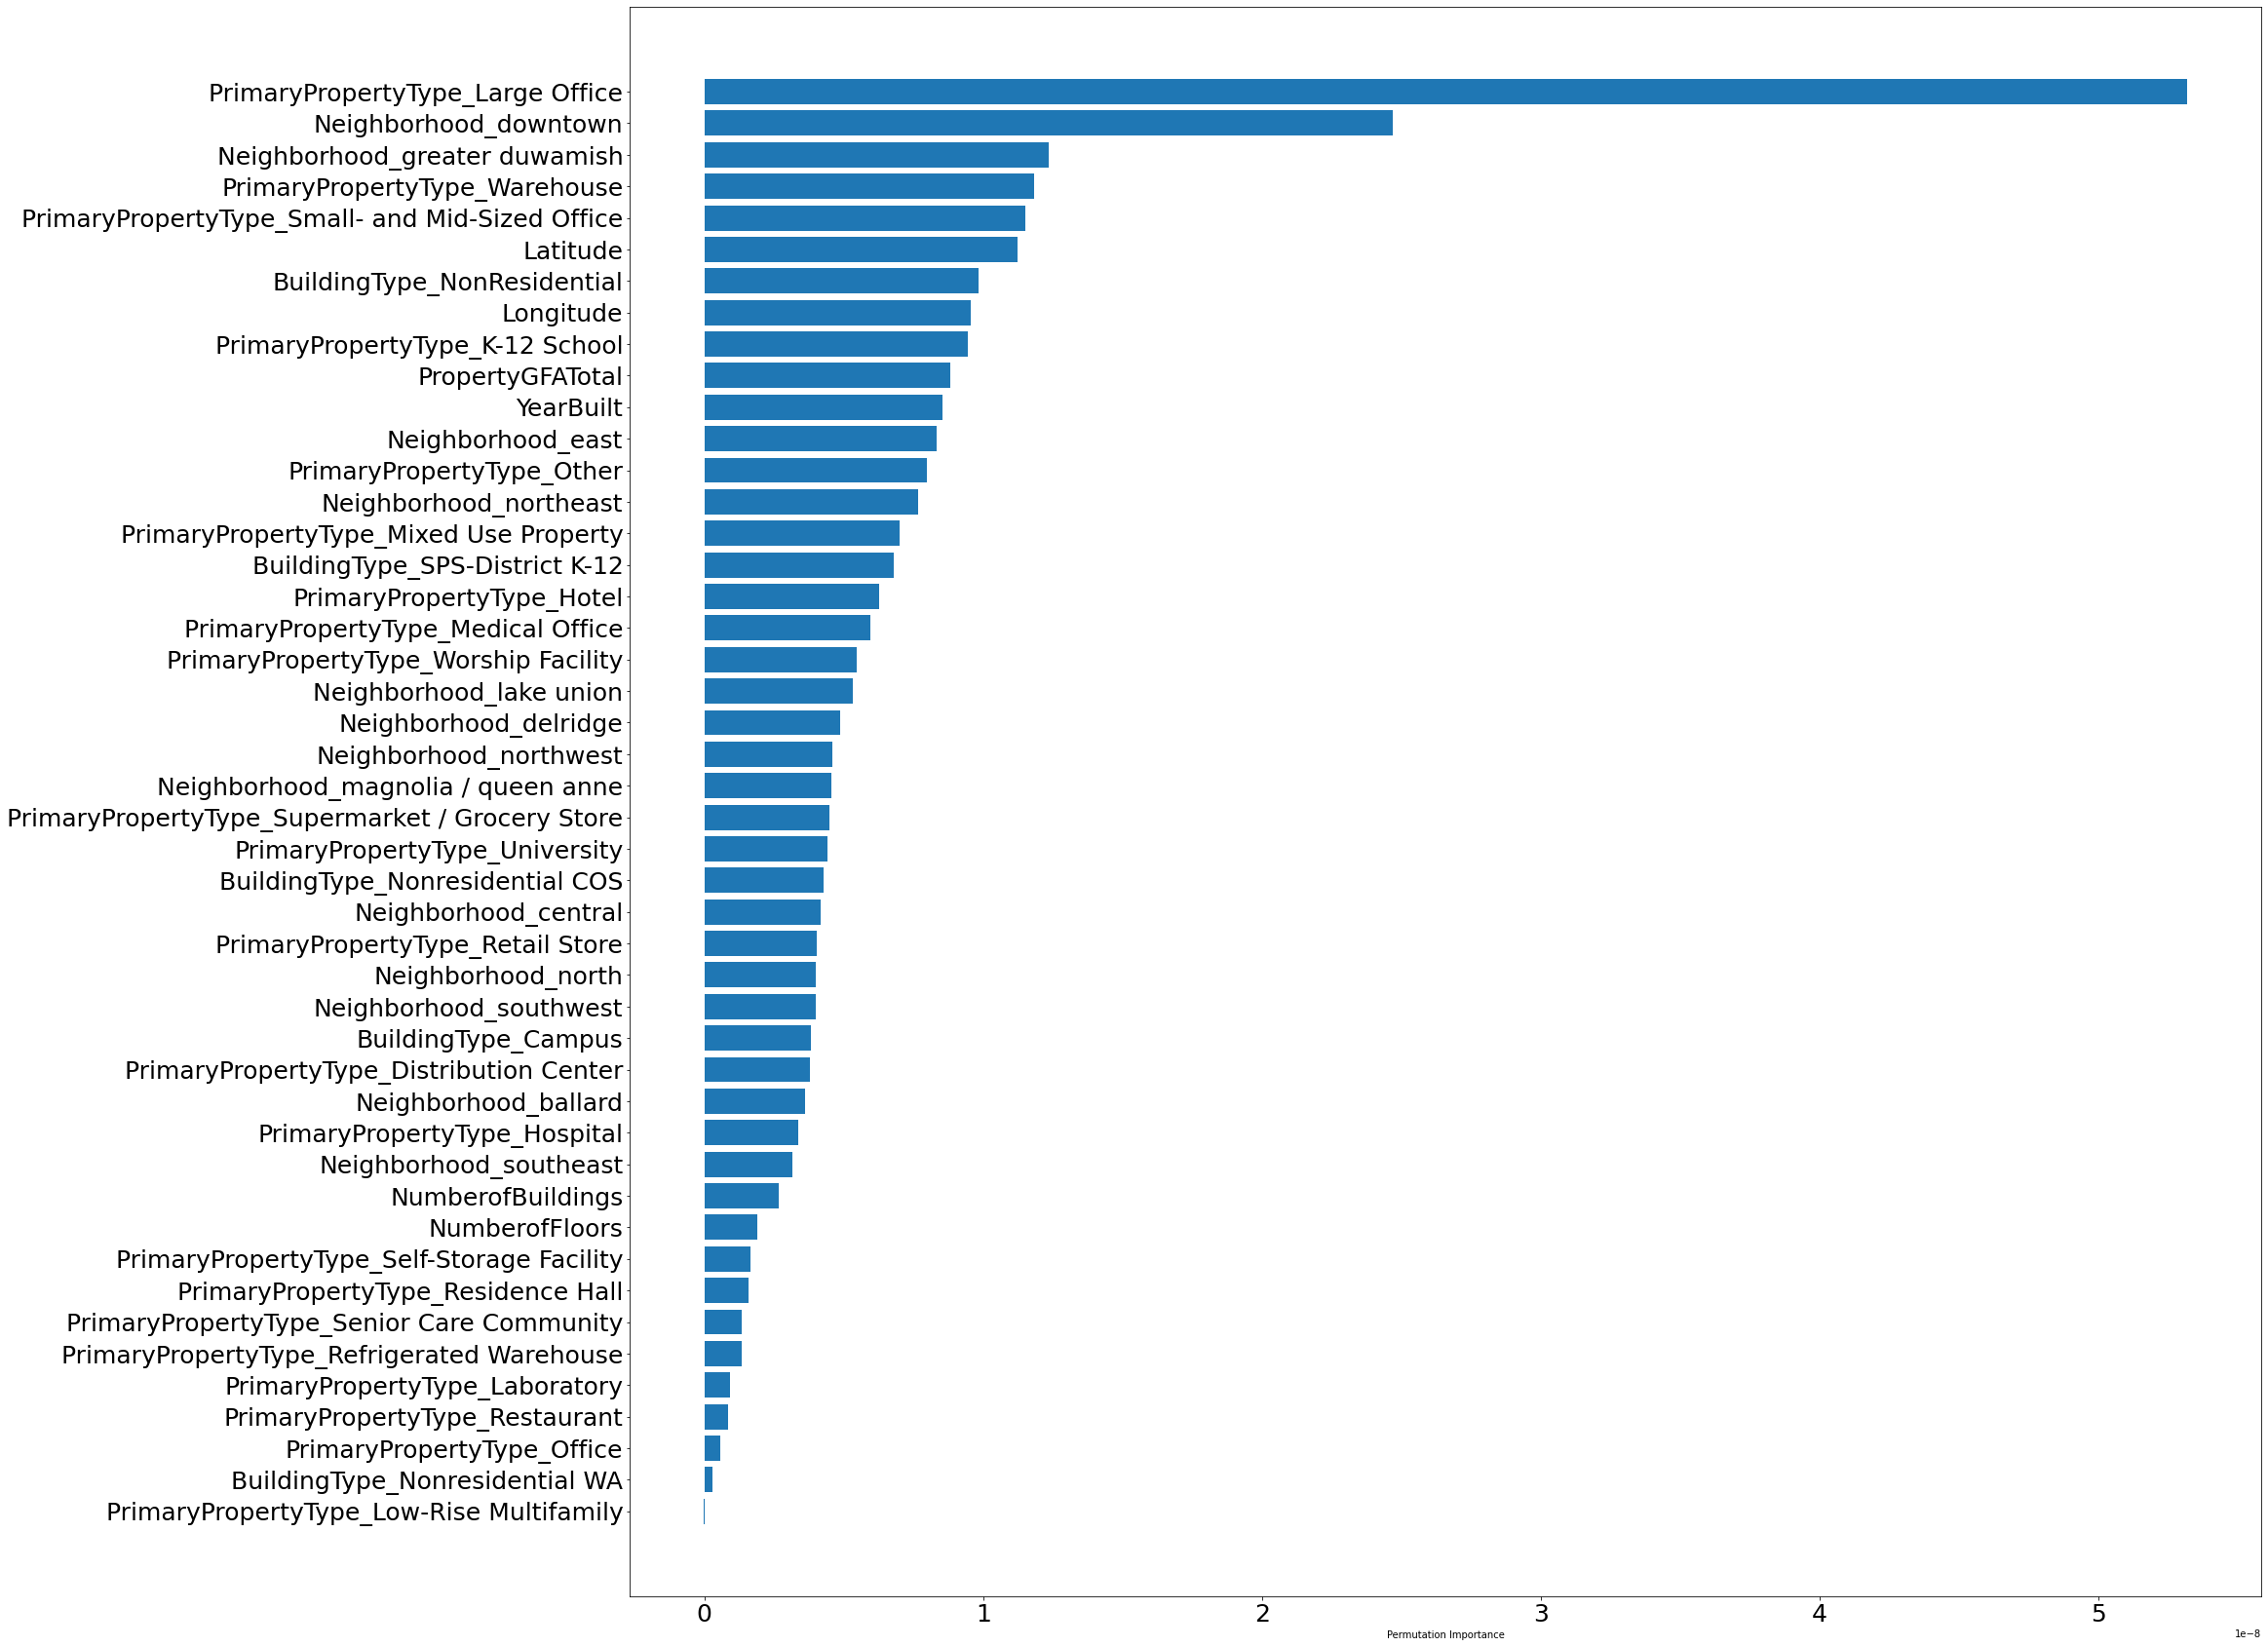

In [73]:
plt.figure(figsize=(30,30))
plt.yticks(
        rotation=0, 
        horizontalalignment='right',
        fontweight='light',
        fontsize=25 
)
plt.xticks(
        rotation=0, 
        fontweight='light',
        fontsize=25
)
sorted_idx2 = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx2], perm_importance.importances_mean[sorted_idx2])
plt.xlabel("Permutation Importance")

In [74]:

C_range = np.logspace(-6, 6, 6)

gamma_range = np.logspace(-6, 6, 4)

# grille de paramètres
param_grid = {'C': C_range, 'gamma': gamma_range}

# score pour sélectionner le modèle optimal
score = 'neg_mean_absolute_error'

# initialiser la validation croisée
grid_pred2 = model_selection.GridSearchCV(svm.SVR(kernel='rbf'),
        param_grid,
        cv=5,
        scoring=score)
                                    
# exécuter la validation croisée sur le jeu d'entraînement
grid_pred2.fit(X_train_std, y_train)

# prédire sur le jeu de test avec le modèle sélectionné 
best_grid2 = grid_pred2.best_estimator_
y_test_pred_cv2 = best_grid2.predict(X_test_std)


/Users/yixuanzhao/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/yixuanzhao/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/yixuanzhao/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/yixuanzhao/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ra

In [75]:
print(grid_pred2.best_params_, grid_pred2.best_score_)

{'C': 1000000.0, 'gamma': 0.01} -6368047.524768653


In [76]:
mae_cv2 = mean_absolute_error(y_test, y_test_pred_cv2)
mse_cv2 = mean_squared_error(y_test, y_test_pred_cv2)
mape_cv2 = mean_absolute_percentage_error(y_test, y_test_pred_cv2)
r2_cv2 = r2_score (y_test, y_test_pred_cv2)

print('MAE : ', mae_cv2, 'r2 : ', r2_cv2)
print('MSE : ', mse_cv2, ' MAPE: ', mape_cv2)

MAE :  4072477.781735019 r2 :  0.23553279571195762
MSE :  114746975143001.78  MAPE:  6.055791782650898e+19


In [77]:

reg2_after = svm.SVR(kernel='rbf', C =1000000.0, gamma= 0.01)

reg2_after.fit(X_train_std, y_train)

y_test_pred2_after = reg2_after.predict(X_test_std)

mae2_after = mean_absolute_error(y_test, y_test_pred2_after)
mse2_after = mean_squared_error(y_test, y_test_pred2_after)
mape2_after = mean_absolute_percentage_error(y_test, y_test_pred2_after)
r2_2_after = r2_score (y_test, y_test_pred2_after)
print('MAE : ', mae2_after, 'r2 : ', r2_2_after)
print('MSE : ', mse2_after, ' MAPE: ', mape2_after)


/Users/yixuanzhao/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MAE :  4072477.781735019 r2 :  0.23553279571195762
MSE :  114746975143001.78  MAPE:  6.055791782650898e+19


In [78]:
grid_pred2.cv_results_['mean_fit_time']

array([0.08143721, 0.07333984, 0.05643678, 0.05472484, 0.07457924,
       0.0738028 , 0.05693498, 0.05532398, 0.07231636, 0.07707691,
       0.05409594, 0.05346875, 0.07364726, 0.075211  , 0.05404892,
       0.05351658, 0.07454729, 0.07496271, 0.05737243, 0.05438433,
       0.07331338, 0.07979836, 0.07143841, 0.06875854])

In [79]:
grid_pred2.cv_results_['mean_score_time']

array([0.065769  , 0.06746879, 0.06375041, 0.06242795, 0.06915908,
       0.06482062, 0.06167836, 0.06114039, 0.06641822, 0.06631026,
       0.05990863, 0.06299872, 0.06635137, 0.06770453, 0.06303849,
       0.06229682, 0.06600151, 0.06464596, 0.06084714, 0.06268659,
       0.06816545, 0.06634521, 0.06133957, 0.06037388])